# Tanzania Water Wells

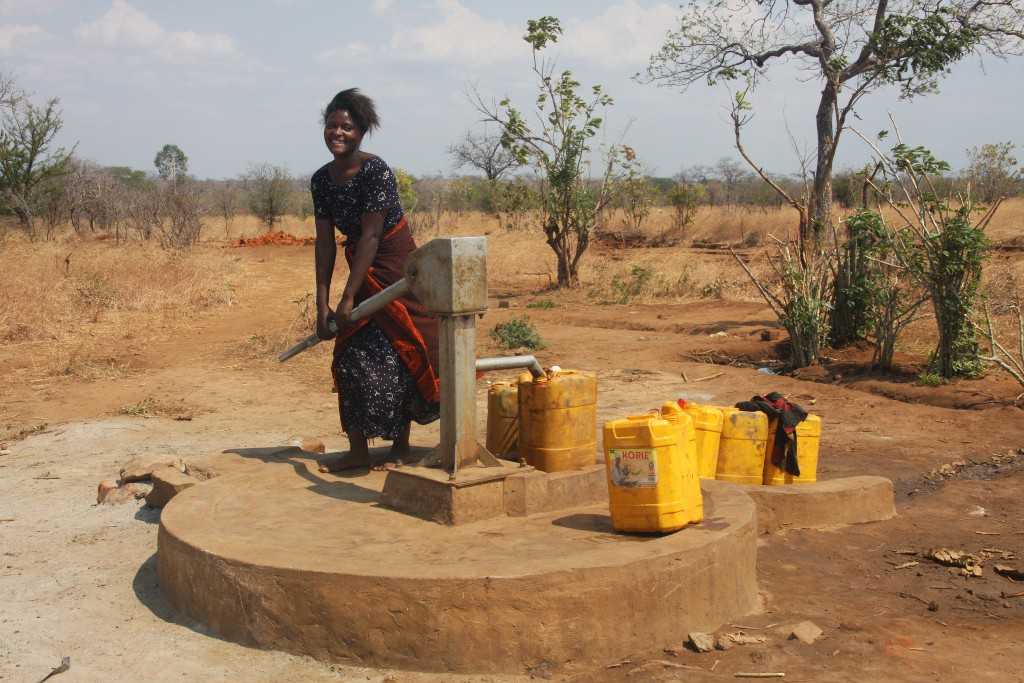

## Overview

For our project, we wanted to deliver a model to the government of Tanzania to help them predict the functionality of water wells. We used data from 59,400 wells that were previously recorded. Since the target was binary, we tried multiple classification models. Our final model ended up being a Random Forest Tree classifier. It had a precision score of 0.8 and was also not overfit to the training data. We focused on precision because we wanted to minimize the cost of a false positive result. In the end, we recommend the government of Tanzania us our model to predict the functionality of wells that it hasn't seen, and to take note of important features in case it wants to build more water wells in the future. 

## Business Problem

As a developing country, it isn't given that the people of Tanzania will have fresh water. We want to be able to predict the functionality of water wells in Tanzania. This will help the Government of Tanzania focus their time and resources on repairing certain wells.

- Who are your stakeholders?
    - Stakeholders are the Government of Tanzania who will help fund and maintain the water wells.
- What are your stakeholders' pain points related to this project?
    - Their pain points are wasted resources on wells and not delivering enough water to the people of Tanzania.
- Why are your predictions important from a business perspective?
    - They are important because they allow us to allocate resources in the best way. Ultimately, the priority is giving clean water to the people of Tanzania.
- What exactly is your deliverable: your analysis, or the model itself?
    - Our deliverable is the model itself. We used a Random Forest Classifier model and its precision score to show which wells were functioning. This in turn allowed us to understand which wells needed to be maintained.
- Does your business understanding/stakeholder require a specific type of model?
    - They do not need a specific type of model. The model itself is the deliverable. Being able to predict which wells are functioning from the model is the key. This allows us to use a stronger, more complex model
- What does a false positive look like in this context?
    - A false positive in this context is a well that needs repair but is predicted to be functioning.
- What does a false negative look like in this context?
    - A false negative in this context is a well that is functioning but is predicted to need repair.
- Which is worse for your stakeholder?
    - The thing that is worse for the stakeholders is a false positive. They are trying to repair the wells and ignoring one that isn’t operational is bad for the people of Tanzania.
- What metric are you focusing on optimizing, given the answers to the above questions?
    - We are focusing on optimizing precision throughout this modeling.

## Data Understanding

The source of the data is the government of Tanzania and Taarifa. We collected the data from this data science competition website <br> https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/<br>After importing our necessary tools, we had to merge the features and target datasets into 1 DataFrame. Then we manipulated our target variable into 1's and 0's. We explored how many null values and unique values each feature had.

- Where did the data come from, and how do they relate to the data analysis questions?
    - The data was provided from a website titled DrivenData. It involved a dataset that included 59,400 wells with all of the crucial info on them.
- What do the data represent? Who is in the sample and what variables are included?
    - The data represents the wells in Tanzania and their construction. It goes through things such as the provider of the money for the well, the type of well that was dug as well as what type of water source it is being pumped from.
- What is the target variable?
    - The data provided a ternary target variable, `functional`, `functional needs repair`, and `non functional`. We turned the target variable into a binary classification problem, focusing on whether a well is functioning or needs repair. 

In [1]:
#pip install category_encoders

In [2]:
#Import Utilities
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt  

import category_encoders as ce

In [3]:
#Find location of datasets
!ls

Data                     MainNotebookDragon.ipynb README.md
Images                   Notebook                 presentation.pdf


In [4]:
!ls Data

test_set_variables.csv     training_set_variables.csv
training_set_values.csv


In [5]:
#read target variables
df_variables = pd.read_csv('Data/training_set_variables.csv')
df_variables.head()

id    status_group
0  69572      functional
1   8776      functional
2  34310      functional
3  67743  non functional
4  19728      functional

In [6]:
#read feature values
df_values = pd.read_csv('data/training_set_values.csv')
df_values.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... payment_type  \
0  34.938093  -9.856322                  none            0  ...     annually   
1  34.698766  -2.147466              Zahanati            0  ...    never pay   
2  37.460664  -3.821329           Kwa Mahundi            0  ...   per bucket   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...    never pay   
4  31.130847  -1.825359               Shuleni            0  ...    never pay   

  water_quality quality_group      quantity  quantity_group  \
0          soft          good        enough          enough   
1          soft          good  insufficient    insufficient   
2          soft          good        enough          enough   
3          soft          good           dry             dry   
4          soft          good      seasonal        seasonal   

                 source           source_type  source_class  \
0                spring                spring   groundwater   
1  rainwater harvesting  rainwater harvesting       surface   
2                   dam                   dam       surface   
3           machine dbh              borehole   groundwater   
4  rainwater harvesting  rainwater harvesting       surface   

               waterpoint_type waterpoint_type_group  
0           communal standpipe    communal standpipe  
1           communal standpipe    communal standpipe  
2  communal standpipe multiple    communal standpipe  
3  communal standpipe multiple    communal standpipe  
4           communal standpipe    communal standpipe  

[5 rows x 40 columns]

In [7]:
#Merge target and features into 1 dataframe
df = df_variables.merge(df_values, left_on='id', right_on='id')
df.head()

id    status_group  amount_tsh date_recorded        funder  gps_height  \
0  69572      functional      6000.0    2011-03-14         Roman        1390   
1   8776      functional         0.0    2013-03-06       Grumeti        1399   
2  34310      functional        25.0    2013-02-25  Lottery Club         686   
3  67743  non functional         0.0    2013-01-28        Unicef         263   
4  19728      functional         0.0    2011-07-13   Action In A           0   

      installer  longitude   latitude              wpt_name  ...  \
0         Roman  34.938093  -9.856322                  none  ...   
1       GRUMETI  34.698766  -2.147466              Zahanati  ...   
2  World vision  37.460664  -3.821329           Kwa Mahundi  ...   
3        UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu  ...   
4       Artisan  31.130847  -1.825359               Shuleni  ...   

   payment_type water_quality quality_group      quantity  quantity_group  \
0      annually          soft          good        enough          enough   
1     never pay          soft          good  insufficient    insufficient   
2    per bucket          soft          good        enough          enough   
3     never pay          soft          good           dry             dry   
4     never pay          soft          good      seasonal        seasonal   

                 source           source_type source_class  \
0                spring                spring  groundwater   
1  rainwater harvesting  rainwater harvesting      surface   
2                   dam                   dam      surface   
3           machine dbh              borehole  groundwater   
4  rainwater harvesting  rainwater harvesting      surface   

               waterpoint_type waterpoint_type_group  
0           communal standpipe    communal standpipe  
1           communal standpipe    communal standpipe  
2  communal standpipe multiple    communal standpipe  
3  communal standpipe multiple    communal standpipe  
4           communal standpipe    communal standpipe  

[5 rows x 41 columns]

In [8]:
#Explore target values
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

We are only going to focus on water wells that need repair. It doesn't matter if it's functional or not. Therefore, we will combine `non functional` and `functional needs repair` into one target.

In [9]:
#Create a Target column of 0's and 1's
df['target'] = (df['status_group'] == 'functional').astype(int)

In [10]:
#Explore Target value counts
df['target'].value_counts()

1    32259
0    27141
Name: target, dtype: int64

In [11]:
#Explore Target percentages
df['target'].value_counts(normalize=True)

1    0.543081
0    0.456919
Name: target, dtype: float64

In [12]:
df.head()

id    status_group  amount_tsh date_recorded        funder  gps_height  \
0  69572      functional      6000.0    2011-03-14         Roman        1390   
1   8776      functional         0.0    2013-03-06       Grumeti        1399   
2  34310      functional        25.0    2013-02-25  Lottery Club         686   
3  67743  non functional         0.0    2013-01-28        Unicef         263   
4  19728      functional         0.0    2011-07-13   Action In A           0   

      installer  longitude   latitude              wpt_name  ...  \
0         Roman  34.938093  -9.856322                  none  ...   
1       GRUMETI  34.698766  -2.147466              Zahanati  ...   
2  World vision  37.460664  -3.821329           Kwa Mahundi  ...   
3        UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu  ...   
4       Artisan  31.130847  -1.825359               Shuleni  ...   

   water_quality quality_group      quantity quantity_group  \
0           soft          good        enough         enough   
1           soft          good  insufficient   insufficient   
2           soft          good        enough         enough   
3           soft          good           dry            dry   
4           soft          good      seasonal       seasonal   

                 source           source_type source_class  \
0                spring                spring  groundwater   
1  rainwater harvesting  rainwater harvesting      surface   
2                   dam                   dam      surface   
3           machine dbh              borehole  groundwater   
4  rainwater harvesting  rainwater harvesting      surface   

               waterpoint_type  waterpoint_type_group target  
0           communal standpipe     communal standpipe      1  
1           communal standpipe     communal standpipe      1  
2  communal standpipe multiple     communal standpipe      1  
3  communal standpipe multiple     communal standpipe      0  
4           communal standpipe     communal standpipe      1  

[5 rows x 42 columns]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

In [14]:
#Explore Numeric columns
df.describe()

id     amount_tsh    gps_height     longitude      latitude  \
count  59400.000000   59400.000000  59400.000000  59400.000000  5.940000e+04   
mean   37115.131768     317.650385    668.297239     34.077427 -5.706033e+00   
std    21453.128371    2997.574558    693.116350      6.567432  2.946019e+00   
min        0.000000       0.000000    -90.000000      0.000000 -1.164944e+01   
25%    18519.750000       0.000000      0.000000     33.090347 -8.540621e+00   
50%    37061.500000       0.000000    369.000000     34.908743 -5.021597e+00   
75%    55656.500000      20.000000   1319.250000     37.178387 -3.326156e+00   
max    74247.000000  350000.000000   2770.000000     40.345193 -2.000000e-08   

        num_private   region_code  district_code    population  \
count  59400.000000  59400.000000   59400.000000  59400.000000   
mean       0.474141     15.297003       5.629747    179.909983   
std       12.236230     17.587406       9.633649    471.482176   
min        0.000000      1.000000       0.000000      0.000000   
25%        0.000000      5.000000       2.000000      0.000000   
50%        0.000000     12.000000       3.000000     25.000000   
75%        0.000000     17.000000       5.000000    215.000000   
max     1776.000000     99.000000      80.000000  30500.000000   

       construction_year        target  
count       59400.000000  59400.000000  
mean         1300.652475      0.543081  
std           951.620547      0.498145  
min             0.000000      0.000000  
25%             0.000000      0.000000  
50%          1986.000000      1.000000  
75%          2004.000000      1.000000  
max          2013.000000      1.000000

In [15]:
#Explore Object columns
df[[c for c in df.columns if df[c].dtype == 'object']].describe()

status_group date_recorded                  funder installer wpt_name  \
count         59400         59400                   55765     55745    59400   
unique            3           356                    1897      2145    37400   
top      functional    2011-03-15  Government Of Tanzania       DWE     none   
freq          32259           572                    9084     17402     3563   

                basin subvillage  region     lga   ward  ... payment_type  \
count           59400      59029   59400   59400  59400  ...        59400   
unique              9      19287      21     125   2092  ...            7   
top     Lake Victoria   Madukani  Iringa  Njombe  Igosi  ...    never pay   
freq            10248        508    5294    2503    307  ...        25348   

       water_quality quality_group quantity quantity_group  source  \
count          59400         59400    59400          59400   59400   
unique             8             6        5              5      10   
top             soft          good   enough         enough  spring   
freq           50818         50818    33186          33186   17021   

       source_type source_class     waterpoint_type waterpoint_type_group  
count        59400        59400               59400                 59400  
unique           7            3                   7                     6  
top         spring  groundwater  communal standpipe    communal standpipe  
freq         17021        45794               28522                 34625  

[4 rows x 31 columns]

In [16]:
#Number of unique values in the Object columns
df[[c for c in df.columns if df[c].dtype == 'object']].nunique().sort_values(ascending = False)

wpt_name                 37400
subvillage               19287
scheme_name               2696
installer                 2145
ward                      2092
funder                    1897
date_recorded              356
lga                        125
region                      21
extraction_type             18
extraction_type_group       13
management                  12
scheme_management           12
source                      10
basin                        9
water_quality                8
payment_type                 7
extraction_type_class        7
waterpoint_type              7
source_type                  7
payment                      7
waterpoint_type_group        6
quality_group                6
management_group             5
quantity                     5
quantity_group               5
source_class                 3
status_group                 3
public_meeting               2
permit                       2
recorded_by                  1
dtype: int64

In [17]:
df.isnull().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

## Data Preparation

We did 2 Train_Test_Splits. The first was to create a dataset that we would hold until the very end to evaluate our final model. The second split was on the data that wasn't held til the end (`X_use`). This allowed us to evaluate our model while preventing Data Leakage. 

- Were there variables you dropped or created?
    - There were multiple columns that had overlap with each other. We took out the redundancy to make the data cleaner and easier to work with. We also took out columns that had no impact on well functionality. If you look at the cell of code that creates a list of unused columns, we put a comment of why each one was dropped. 
- How did you address missing values or outliers?
    - We used a Simple Imputer to insert missing values.
- Why are these choices appropriate given the data and the business problem?
    - These choices are appropriate because we are working with discrete data and not continuous.
- Can you pipeline your preparation steps to use them consistently in the modeling process?
    - Yes a pipeline was built so that consistency was achieved, streamlining the process for training and testing the data.

### Train Test Split

In [18]:
# Define our X and y

X = df.drop(columns=['target', 'status_group'])
y = df['target']

# and train test split - to create our holdout set!
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.1, # saving 10%
                                                  random_state=42)

# and 2nd train test split - to create our test set!
X_train, X_test, y_train, y_test = train_test_split(X_use, y_use, test_size=0.25, # saving 25%
                                                  random_state=42)

In [19]:
#Columns that won't be used because it's not necessary
not_used_cols = ['waterpoint_type', #too similar to waterpoint_type_group
                 'subvillage', #too many unique values
                 'wpt_name', #too many unique values
                 'source_type', #too similar to source column
                 'quantity_group', #too similar to quantity
                 'water_quality', #too similar to quality group
                 'payment_type', #not needed to make a prediction on well functionality
                 'management', #too similar to management group
                 'extraction_type', #too similar to extraction type class
                 'extraction_type_group', #too similar to extraction type class
                 'scheme_name', #too many nulls
                 'region_code', #too similar to region
                 'id', #not needed to make a prediction on well functionality
                 'longitude', #too many have a 0 value and we're using region and district
                 'latitude', #too many have a 0 value and we're using region and district
                 'date_recorded', #not needed to make a prediction on well functionality
                 'payment', #not needed to make a prediction on well functionality
                 'recorded_by'] #not needed to make a prediction on well functionality

In [20]:
#Columns we will use because we think they will have an impact on our predictions
used_cols = ['amount_tsh', 
             'funder', 
             'gps_height', 
             'installer',
             'num_private',
             'basin', 
             'region', 
             'district_code', 
             'lga',
             'ward',
             'population', 
             'public_meeting', 
             'scheme_management', 
             'permit', 
             'construction_year',
             'extraction_type_class', 
             'management_group',
             'quality_group',
             'quantity',
             'source', 
             'source_class', 
             'waterpoint_type_group']

In [21]:
X_train_used_cols = X_train[used_cols]
X_test_used_cols = X_test[used_cols]

In [22]:
X_train_used_cols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40095 entries, 39528 to 47473
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             40095 non-null  float64
 1   funder                 37612 non-null  object 
 2   gps_height             40095 non-null  int64  
 3   installer              37598 non-null  object 
 4   num_private            40095 non-null  int64  
 5   basin                  40095 non-null  object 
 6   region                 40095 non-null  object 
 7   district_code          40095 non-null  int64  
 8   lga                    40095 non-null  object 
 9   ward                   40095 non-null  object 
 10  population             40095 non-null  int64  
 11  public_meeting         37862 non-null  object 
 12  scheme_management      37480 non-null  object 
 13  permit                 37986 non-null  object 
 14  construction_year      40095 non-null  int64  
 15

#### Split up used columns by category and number of unique values
Source for code: <br> https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb

In [23]:
# Set up lists for columns requiring different treatment
num_cols = []
ohe_cols = []
freq_cols = []

for c in X_train_used_cols.columns:
    if X_train_used_cols[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X_train_used_cols[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [24]:
print("NUMBER COLUMNS")
print(num_cols)
print('*'*10)
print("OHE COLUMNS")
print(ohe_cols)
print('*'*10)
print("FREQ COLUMNS")
print(freq_cols)

NUMBER COLUMNS
['amount_tsh', 'gps_height', 'num_private', 'district_code', 'population', 'construction_year']
**********
OHE COLUMNS
['basin', 'public_meeting', 'permit', 'extraction_type_class', 'management_group', 'quality_group', 'quantity', 'source_class', 'waterpoint_type_group']
**********
FREQ COLUMNS
['funder', 'installer', 'region', 'lga', 'ward', 'scheme_management', 'source']


In [25]:
print(X_train['public_meeting'].value_counts())
print(X_train['permit'].value_counts())

True     34442
False     3420
Name: public_meeting, dtype: int64
True     26216
False    11770
Name: permit, dtype: int64


In [26]:
#Create a list of boolean columns and remove from ohe_cols
#This will help with the simple imputer
bool_cols=['public_meeting','permit']
ohe_cols.remove('public_meeting')
ohe_cols.remove('permit')
print(ohe_cols)

['basin', 'extraction_type_class', 'management_group', 'quality_group', 'quantity', 'source_class', 'waterpoint_type_group']


#### Preprocess with Pipeline

In [27]:
#Replace null values in numerical columns with the median
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ])
#Replace null values in boolean columns with 'False'
#Then OneHotEncode the columns
bool_transformer = Pipeline(steps=[
    ('bool_imputer', SimpleImputer(strategy='constant', fill_value=False)),
    ('bool_encoder', OneHotEncoder(handle_unknown='error'))
])
#Replace null values in categorical columns with 'Unknown'
#Then OneHotEncode the columns
ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('oh_encoder', OneHotEncoder(handle_unknown='error'))
])
#Replace null values in categorical columns that have a high number of unique values with 0
#Then use a CountEncoder on the columns
freq_transformer = Pipeline(steps=[
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05))
])

In [28]:
# Package those pieces together using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('bool', bool_transformer, bool_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('freq', freq_transformer, freq_cols)
    ])

In [29]:
preprocessor.fit(X_train_used_cols)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['amount_tsh', 'gps_height', 'num_private',
                                  'district_code', 'population',
                                  'construction_year']),
                                ('bool',
                                 Pipeline(steps=[('bool_imputer',
                                                  SimpleImputer(fill_value=False,
                                                                strategy='constant')),
                                                 ('bool_encoder',
                                                  OneHotEncoder())]),
                                 ['public_meeting', 'permi...
                                 ['basin', 'extraction_type_class',
                                  'management_group', 'quality_grou

## Modeling

We each ran multiple models while tuning the hyperparameters in order to achieve the best results.

- How will you analyze the data to arrive at an initial approach?
    - Before we begin modeling, we looked at our baseline understaning. If our model predicted a well was functional every time, it would be accurate 54% of the time. Knowing this, our initial approach will be to run a simple Logistic Regression model. 
- How will you iterate on your initial approach to make it better?
    - We ran untuned Decision Tree Classifier, K-Nearest Neighbors, and Random Forest Classifier models. Then we will tune the hyperparameters using a GridSearchCV with the goal of increasing our precision while not overfitting to the training data. 
- What model type is most appropriate, given the data and the business problem?
    - Since the target is binary, our models will be classification. And since our goal is to deliver a model and not just analysis, we care little about how to interpret the model. This means that we aren't limited to logistic regression or a simple decision tree, both of which are easy for interpretation. We can run complicated, non-parametric models like a K nearest neighbors or Random Forest Classifier model. 

## Evaluation 

After each model we ran, we predicted what the outcome would be. Then we compared our predicted data with the real target values. This allowed us to evaluate how well each model was performing. The specific metric we would look at is the precision score. We used precision score because it is worse for us to predict a well is function when it's in need of repair. We also wanted to check the scores on the training set because we didn't want to overfit our models.

- How do you interpret the results?
    - We used precision score to interpret the results. We also looked at Accuracy and Roc-Auc score since it was easy to code but it wasn't our main priority. It was only used to enhance our belief in the precision score.
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
    - Our baseline line model was an untuned Decision Tree Classifier. Since the hyperparameters weren't tuned, it was overfit to our training data. For every model iteration after that, we compared the precision score of the training and testing datasets to decide which model was best.
- How well does your model/data fit any relevant modeling assumptions?
    - As for the assumptions of Linear modeling, we weren't too concerned with multicollinearity because we used a Logistic Regression that uses an L2 penalty for regularization. As for our other models like KNN and Random Forest Classifier, they didn't have any modeling assumptions. Ultimately, since our deliverable was the model itself, we weren't concerned about analyzing how each coefficient effected the prediction.
- How confident are you that your results would generalize beyond the data you have?
    - We are confident that our final model would be generalizable beyond our training data because the precision score on the training and testing sets were very similar (only off by ~0.02).
- How confident are you that this model would benefit the business if put into use?
    - We are confident that our final model would benefit the business if put to use because we believe 80% precision score is high.
- What does this final model tell you about the relationship between your inputs and outputs?
    - Our inputs do have an effect on predicting the outputs. Our most important features for the final model was if the quantity of the well was dry, the year the well was constructed, and ward in which it is located.

### Baseline Understanding

In [30]:
y_train.value_counts()

1    21857
0    18238
Name: target, dtype: int64

In [31]:
y_train.value_counts(normalize=True)

1    0.54513
0    0.45487
Name: target, dtype: float64

This means that our model would be 54% accurate even if it predicted a 1 everytime (a functional well)

### First Subpar Model: Decision Tree Classifier

We chose a simple decision tree classifier to get our first model results because it's easy to make and interpret.

In [32]:
# Create a pipeline for default Desicion Tree Classifier
pipe_dtc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dtc', DecisionTreeClassifier(random_state=42))
])

In [33]:
#Cross validate on y_train
cv = cross_validate(pipe_dtc, X_train_used_cols, y_train, return_train_score=True, \
                    scoring=['accuracy', 'precision','roc_auc'])
cv

{'fit_time': array([0.65694571, 0.69040203, 0.67816496, 0.65488195, 0.64782   ]),
 'score_time': array([0.14877915, 0.16384697, 0.15841794, 0.14680004, 0.15104485]),
 'test_accuracy': array([0.76854969, 0.76505799, 0.76094276, 0.76393565, 0.77478489]),
 'train_accuracy': array([0.96224592, 0.96336825, 0.96156004, 0.96243297, 0.9624018 ]),
 'test_precision': array([0.78888123, 0.78267788, 0.78495123, 0.78818879, 0.79521399]),
 'train_precision': array([0.96732326, 0.96690903, 0.96998438, 0.96674312, 0.96711621]),
 'test_roc_auc': array([0.78177028, 0.78097779, 0.77344609, 0.77663982, 0.79000167]),
 'train_roc_auc': array([0.99634843, 0.99660445, 0.99633459, 0.99641553, 0.99643584])}

In [34]:
#Fit the Decision Tree Classifier on X_train_used_cols and y_train
pipe_dtc.fit(X_train_used_cols, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('bool',
                                                  Pipeline(steps=[('bool_imputer',
                                                                   SimpleImputer(fill_value=False,
                                                                                 strategy='constant')),
                            

In [35]:
#Make predictions for model
train_preds = pipe_dtc.predict(X_train_used_cols)
train_probas = pipe_dtc.predict_proba(X_train_used_cols)[:,1]
test_preds = pipe_dtc.predict(X_test_used_cols)
test_probas = pipe_dtc.predict_proba(X_test_used_cols)[:,1]

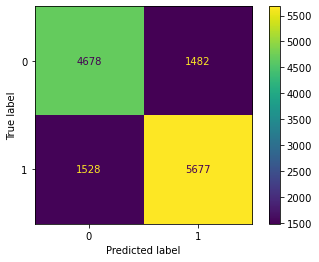

In [36]:
#Visualize Confusion Matrix
plot_confusion_matrix(pipe_dtc, X_test_used_cols, y_test)

In [37]:
# Evaluate Train and Test Scores
print("Train Scores:")
print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Train Precision: {precision_score(y_train, train_preds)}")
print(f"Train Recall: {recall_score(y_train, train_preds)}")
print(f"Train F1-Score: {f1_score(y_train, train_preds)}")
print(f"Train Roc-Auc Score: {roc_auc_score(y_train, train_probas)}")
print("---------------")
print("Test Scores:")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")
print(f"Test Precision: {precision_score(y_test, test_preds)}")
print(f"Test Recall: {recall_score(y_test, test_preds)}")
print(f"Test F1-Score: {f1_score(y_test, test_preds)}")
print(f"Test Roc-Auc Score: {roc_auc_score(y_test, test_probas)}")

Train Scores:
Train Accuracy: 0.9604439456291308
Train Precision: 0.9657644409723818
Train Recall: 0.961522624330878
Train F1-Score: 0.9636388646888898
Train Roc-Auc Score: 0.9960189333530102
---------------
Test Scores:
Test Accuracy: 0.774784885895997
Test Precision: 0.7929878474647297
Test Recall: 0.7879250520471894
Test F1-Score: 0.790448343079922
Test Roc-Auc Score: 0.7870187212163271


This model is better than our baseline understanding but it is heavily overfitting to the training data. 

## Modeling Iterations

### Model 2: Logistic Regression
The other type of model that is simple and easy to interpret is a Logistic Regression Model. You can check out the code in this link. <br> https://github.com/PattiCakes59/Dragon/blob/main/Notebook/Garrett/Project3Garrett.ipynb
<br> We didn't include it in our main notebook because it's precision score was worse than the decision tree model (0.68)

### Model 3: Random Forest Classifier
Since the Decision Tree Classifier was overfitting, Let's try a Random Forest

In [38]:
#Instantiate a Random Forest Classifier inside this new pipeline
pipe_rfc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfc', RandomForestClassifier(random_state=42))
])

In [39]:
#Cross Validate on X_train_used_cols and y_train
cross_validate(pipe_rfc, X_train_used_cols, y_train, return_train_score=True, \
               scoring=['accuracy', 'precision','roc_auc'])

{'fit_time': array([3.61894512, 3.75761271, 3.62718296, 3.72888875, 3.82111096]),
 'score_time': array([0.49144602, 0.50093198, 0.50513816, 0.54352427, 0.54302812]),
 'test_accuracy': array([0.80745729, 0.80009976, 0.80508792, 0.80246914, 0.81506422]),
 'train_accuracy': array([0.96215239, 0.96336825, 0.96140417, 0.96243297, 0.9624018 ]),
 'test_precision': array([0.80748314, 0.80244755, 0.80911493, 0.80597015, 0.81463733]),
 'train_precision': array([0.95779878, 0.95850902, 0.96064867, 0.95730337, 0.95653149]),
 'test_roc_auc': array([0.88420127, 0.87974155, 0.88226582, 0.88343983, 0.88797291]),
 'train_roc_auc': array([0.99345251, 0.99376546, 0.9935    , 0.99349592, 0.99371484])}

In [40]:
#Fit the Model to X_train_used_cols and y_train
pipe_rfc.fit(X_train_used_cols, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('bool',
                                                  Pipeline(steps=[('bool_imputer',
                                                                   SimpleImputer(fill_value=False,
                                                                                 strategy='constant')),
                            

In [41]:
#Make predictions with this model
train_preds = pipe_rfc.predict(X_train_used_cols)
train_probas = pipe_rfc.predict_proba(X_train_used_cols)[:,1]
test_preds = pipe_rfc.predict(X_test_used_cols)
test_probas = pipe_rfc.predict_proba(X_test_used_cols)[:,1]

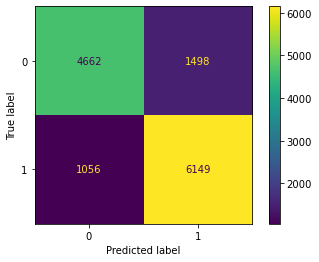

In [42]:
#Visualize Confusion Matrix
plot_confusion_matrix(pipe_rfc, X_test_used_cols, y_test)

In [43]:
#Evaluate our Random Forest Model
print("Train Scores:")
print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Train Precision: {precision_score(y_train, train_preds)}")
print(f"Train Recall: {recall_score(y_train, train_preds)}")
print(f"Train F1-Score: {f1_score(y_train, train_preds)}")
print(f"Train Roc-Auc Score: {roc_auc_score(y_train, train_probas)}")
print("---------------")
print("Test Scores:")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")
print(f"Test Precision: {precision_score(y_test, test_preds)}")
print(f"Test Recall: {recall_score(y_test, test_preds)}")
print(f"Test F1-Score: {f1_score(y_test, test_preds)}")
print(f"Test Roc-Auc Score: {roc_auc_score(y_test, test_probas)}")

Train Scores:
Train Accuracy: 0.9604439456291308
Train Precision: 0.9560404949381327
Train Recall: 0.9721370727913254
Train F1-Score: 0.9640215961163286
Train Roc-Auc Score: 0.9928666193981984
---------------
Test Scores:
Test Accuracy: 0.8089038533482978
Test Precision: 0.8041061854321956
Test Recall: 0.8534351145038168
Test F1-Score: 0.8280366280635605
Test Roc-Auc Score: 0.8867903895202647


Even though our Precision score imporved, our Random Forest Model is still heavily overfitting. 

### Model 4: K Nearest Neighbors
The first complex model we ran was a KNN model. You can view the code at this link. <br>
https://github.com/PattiCakes59/Dragon/blob/Patrick/Notebook/Patrick/Project3Patrick1.ipynb
<br> Our precision score for our default knn model was .776 on test data which is less than .80

### Model 5: Random Forest with Grid Search
Since Random Forest had the highest Precision score of all of our untuned models, we tuned it's hyperparameters using Grid Search. We ran multiple Grid Search's with different hyperparameters, not just the parameters used below (i.e. n_estimators=75 and max_depth=50). We finished with this parameter grid because it provided the best precision without overfitting, and because of time.

In [44]:
#Create a Parameter Grid
param_grid_rfc = {
    "rfc__max_depth" :[30, 35, 40],
    "rfc__min_samples_leaf" : [10, 15, 20],
    "rfc__n_estimators": [45, 50, 55],
    "rfc__class_weight" :['balanced'],
    "rfc__random_state":[42]
}

In [45]:
#Create a Grid Search for Cross Validating
#Our main scoring value is Precision because we want to decrease the False Positives
grid_rfc = GridSearchCV(estimator = pipe_rfc, param_grid=param_grid_rfc, scoring='precision',
                       return_train_score = True)

In [46]:
#Fit the Grid Search on X_train_used_cols and y_train
grid_rfc.fit(X_train_used_cols, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'num_private',
                                                                          'district_code',
                                                                          'population',
                                                                          'construction_year']),
                                                                        ('bool',
          

In [47]:
#Visualize the results from the Grid Search
pd.DataFrame(grid_rfc.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.438916      0.012867         0.125296        0.004714   
1        1.614341      0.059904         0.130486        0.002545   
2        1.688970      0.006637         0.136322        0.001823   
3        1.411697      0.015483         0.121975        0.001957   
4        1.517086      0.018864         0.125505        0.000674   
5        1.625827      0.006943         0.132510        0.000838   
6        1.396256      0.042377         0.119956        0.002200   
7        1.495318      0.016483         0.127946        0.005777   
8        1.651170      0.078660         0.129996        0.006167   
9        1.381925      0.006977         0.118189        0.001356   
10       1.506529      0.005334         0.124031        0.000629   
11       1.688642      0.072861         0.131579        0.003423   
12       1.377979      0.037042         0.117193        0.003893   
13       1.522038      0.080534         0.128531        0.009619   
14       1.578995      0.016299         0.128248        0.002141   
15       1.330843      0.012288         0.113342        0.001210   
16       1.433511      0.003299         0.119264        0.001066   
17       1.553883      0.030517         0.124022        0.001305   
18       1.449249      0.063596         0.118900        0.001648   
19       1.516583      0.008266         0.128736        0.009885   
20       1.779307      0.099794         0.150766        0.015558   
21       1.405609      0.059672         0.118021        0.001819   
22       1.472228      0.009132         0.123424        0.002627   
23       1.573497      0.008204         0.128212        0.002471   
24       1.354319      0.049145         0.117256        0.006621   
25       1.438960      0.018813         0.118642        0.000733   
26       1.543337      0.011765         0.124089        0.000686   

   param_rfc__class_weight param_rfc__max_depth param_rfc__min_samples_leaf  \
0                 balanced                   30                          10   
1                 balanced                   30                          10   
2                 balanced                   30                          10   
3                 balanced                   30                          15   
4                 balanced                   30                          15   
5                 balanced                   30                          15   
6                 balanced                   30                          20   
7                 balanced                   30                          20   
8                 balanced                   30                          20   
9                 balanced                   35                          10   
10                balanced                   35                          10   
11                balanced                   35                          10   
12                balanced                   35                          15   
13                balanced                   35                          15   
14                balanced                   35                          15   
15                balanced                   35                          20   
16                balanced                   35                          20   
17                balanced                   35                          20   
18                balanced                   40                          10   
19                balanced                   40                          10   
20                balanced                   40                          10   
21                balanced                   40                          15   
22                balanced                   40                          15   
23                balanced                   40                          15   
24                balanced                   40                          20   
25                balanced                   

In [48]:
#Get the best parameters from the Grid Search
grid_rfc.best_params_

{'rfc__class_weight': 'balanced',
 'rfc__max_depth': 35,
 'rfc__min_samples_leaf': 10,
 'rfc__n_estimators': 50,
 'rfc__random_state': 42}

In [49]:
#Do a Cross Validation with just the best hyperparameters
cross_validate(grid_rfc.best_estimator_, X_train_used_cols, y_train, return_train_score=True,
              scoring=['accuracy', 'precision','roc_auc'])

{'fit_time': array([1.56592989, 1.53120995, 1.51293588, 1.49961805, 1.51547408]),
 'score_time': array([0.24595928, 0.24807572, 0.24630928, 0.24761081, 0.24602699]),
 'test_accuracy': array([0.7981045 , 0.79186931, 0.79548572, 0.79236813, 0.79897743]),
 'train_accuracy': array([0.83152513, 0.83018456, 0.83040279, 0.83040279, 0.82871929]),
 'test_precision': array([0.7883487 , 0.78793691, 0.78960764, 0.78609174, 0.79150824]),
 'train_precision': array([0.81654789, 0.82122845, 0.82139808, 0.82090904, 0.81750781]),
 'test_roc_auc': array([0.88127237, 0.87548955, 0.87929001, 0.87964594, 0.87924113]),
 'train_roc_auc': array([0.91337643, 0.91463641, 0.91488785, 0.91370639, 0.91351138])}

In [50]:
#Fit Best Estimator on X_train_used_cols
grid_rfc.best_estimator_.fit(X_train_used_cols, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('bool',
                                                  Pipeline(steps=[('bool_imputer',
                                                                   SimpleImputer(fill_value=False,
                                                                                 strategy='constant')),
                            

In [51]:
#Make predictions for model
train_preds = grid_rfc.best_estimator_.predict(X_train_used_cols)
train_probas = grid_rfc.best_estimator_.predict_proba(X_train_used_cols)[:,1]
test_preds = grid_rfc.best_estimator_.predict(X_test_used_cols)
test_probas = grid_rfc.best_estimator_.predict_proba(X_test_used_cols)[:,1]

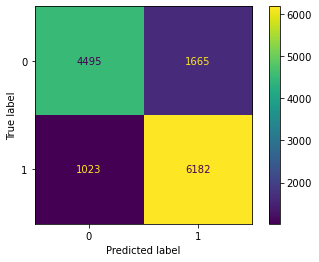

In [52]:
#Visualize Confusion Matrix
plot_confusion_matrix(grid_rfc.best_estimator_, X_test_used_cols, y_test)

In [53]:
#Evaluate the Metrics
print("Train Scores:")
print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Train Precision: {precision_score(y_train, train_preds)}")
print(f"Train Recall: {recall_score(y_train, train_preds)}")
print(f"Train F1-Score: {f1_score(y_train, train_preds)}")
print(f"Train Roc-Auc Score: {roc_auc_score(y_train, train_probas)}")
print("---------------")
print("Test Scores:")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")
print(f"Test Precision: {precision_score(y_test, test_preds)}")
print(f"Test Recall: {recall_score(y_test, test_preds)}")
print(f"Test F1-Score: {f1_score(y_test, test_preds)}")
print(f"Test Roc-Auc Score: {roc_auc_score(y_test, test_probas)}")

Train Scores:
Train Accuracy: 0.831076194039157
Train Precision: 0.8204997450280469
Train Recall: 0.8833783227341355
Train F1-Score: 0.8507788230628566
Train Roc-Auc Score: 0.914500665013553
---------------
Test Scores:
Test Accuracy: 0.7988776655443323
Test Precision: 0.7878170001274373
Test Recall: 0.8580152671755725
Test F1-Score: 0.821419080520861
Test Roc-Auc Score: 0.8840892755752228


### Model 6: K Nearest Neighbors with Grid Search
Even though KNN wasn't our best model, we still ran a Grid Seach on it. You can look at the code at the link below. <br>
https://github.com/PattiCakes59/Dragon/blob/Patrick/Notebook/Patrick/Project3Patrick1.ipynb
<br> With n=4, weights='distance', our precision score for this KNN model on the test data was 0.792 on the test data, but it was really overfit to the training data.

### Model 7: Decision Tree Classifier with Grid Search
And even though Decision Tree Classifier wasn't our best model, we still ran a Grid Seach on it. You can look at the code at the link below.<br>
https://github.com/PattiCakes59/Dragon/blob/Teigen/Teigen's%20Notebook.ipynb
<br>Our precision score was only .84 on the test set with ccp_alpha=0.0, class_weight=balanced', criterion='gini', max_depth=2, max_features='auto', max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=2, random_state=2, and splitter='best'. Even though it had a higher precision score, it was overfit to the test data.

### Model 8: Logistic Regression with Grid Search
And even though Logistic Regression wasn't our best model, we still ran a Grid Seach on it. You can look at the code at the link below. <br>
https://github.com/PattiCakes59/Dragon/blob/main/Notebook/Garrett/Project3Garrett.ipynb
<br>With C=1, class_weight='balanced', and max_iter=500, our precision score was only .67 on the test set

### Final Model

Since we are delivering a model to the non-profit organization, we want our final model to be the one that performs the best on unseen data. This means we want it to be generalizable and not want it to overfit to the training data. Therefore, our final model will be a Random Forest Classifier with class_weight='balanced', max_depth=35, min_samples_leaf=10, n_estimators=50, and random_state=42. Since this was our final model, we wanted to fit it to all of the used data (X_train and X_test) and then test it on our hold out set (X_hold).

In [54]:
#Our final model
final_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfc_final', RandomForestClassifier(random_state=42, class_weight='balanced', 
                                         max_depth=35, min_samples_leaf=10, n_estimators=50))
])

In [55]:
#Only look at certain features from the X_use and X_hold sets
X_use_used_cols = X_use[used_cols]
X_hold_used_cols = X_hold[used_cols]

In [56]:
#Cross validate on the whole training data we use from the first train_test_split
cross_validate(final_pipe, X_use_used_cols, y_use, return_train_score=True, \
               scoring=['accuracy', 'precision','roc_auc'])

{'fit_time': array([2.12639594, 2.08400702, 2.09193778, 2.0940671 , 2.17422199]),
 'score_time': array([0.33014894, 0.31609201, 0.31704116, 0.31627107, 0.32233024]),
 'test_accuracy': array([0.79545455, 0.79723158, 0.80256266, 0.80798728, 0.79704452]),
 'train_accuracy': array([0.83101852, 0.83211747, 0.82975589, 0.83167321, 0.82917134]),
 'test_precision': array([0.79129177, 0.79399903, 0.79631705, 0.79961741, 0.79238921]),
 'train_precision': array([0.82126243, 0.82195953, 0.82264517, 0.82268505, 0.82127025]),
 'test_roc_auc': array([0.88375744, 0.88454164, 0.88704948, 0.8885294 , 0.87917753]),
 'train_roc_auc': array([0.91537939, 0.91469857, 0.9142633 , 0.91484283, 0.91525615])}

In [57]:
#Fit final model to all of the training data
final_pipe.fit(X_use_used_cols, y_use)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('bool',
                                                  Pipeline(steps=[('bool_imputer',
                                                                   SimpleImputer(fill_value=False,
                                                                                 strategy='constant')),
                            

In [58]:
#Make final predictions with this model
use_preds = final_pipe.predict(X_use_used_cols)
use_probas = final_pipe.predict_proba(X_use_used_cols)[:,1]
hold_preds = final_pipe.predict(X_hold_used_cols)
hold_probas = final_pipe.predict_proba(X_hold_used_cols)[:,1]

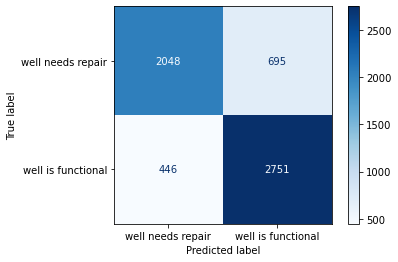

In [59]:
#Visualize Confusion Matrix with correct labels and better colors
plot_confusion_matrix(final_pipe, X_hold_used_cols, y_hold, 
                      display_labels = ['well needs repair','well is functional'], cmap='Blues');  

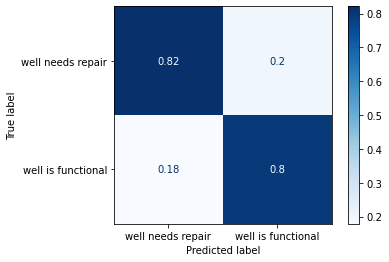

In [60]:
#Confusion Matrix used for our Presentation
#This normalizes the values based on our predicitions to help illustrate our false positives and precision score
plot_confusion_matrix(final_pipe, X_hold_used_cols, y_hold, 
                      display_labels = ['well needs repair','well is functional'], cmap='Blues', normalize = 'pred'); 

In [61]:
#Evaluate the Metrics for our final model
print("Train Scores:")
print(f"Train Accuracy: {accuracy_score(y_use, use_preds)}")
print(f"Train Precision: {precision_score(y_use, use_preds)}")
print(f"Train Recall: {recall_score(y_use, use_preds)}")
print(f"Train F1-Score: {f1_score(y_use, use_preds)}")
print(f"Train Roc-Auc Score: {roc_auc_score(y_use, use_probas)}")
print("---------------")
print("Test Scores:")
print(f"Test Accuracy: {accuracy_score(y_hold, hold_preds)}")
print(f"Test Precision: {precision_score(y_hold, hold_preds)}")
print(f"Test Recall: {recall_score(y_hold, hold_preds)}")
print(f"Test F1-Score: {f1_score(y_hold, hold_preds)}")
print(f"Test Roc-Auc Score: {roc_auc_score(y_hold, hold_probas)}")

Train Scores:
Train Accuracy: 0.8340254395809952
Train Precision: 0.8252827635098121
Train Recall: 0.8812538710343404
Train F1-Score: 0.8523504451285464
Train Roc-Auc Score: 0.9166123614986217
---------------
Test Scores:
Test Accuracy: 0.8079124579124579
Test Precision: 0.798316889146837
Test Recall: 0.8604942133249922
Test F1-Score: 0.8282402528977871
Test Roc-Auc Score: 0.890650081972812


#### Feature Importance

I used this source to get help creating a dataframe with feature importance <br>
https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb

In [62]:
bool_cols_transformed = final_pipe['preprocessor'].transformers_[1][1]['bool_encoder'].get_feature_names(bool_cols)
bool_cols_transformed

array(['public_meeting_False', 'public_meeting_True', 'permit_False',
       'permit_True'], dtype=object)

In [63]:
len(bool_cols_transformed)

4

In [64]:
ohe_cols_transformed = final_pipe['preprocessor'].transformers_[2][1]['oh_encoder'].get_feature_names(ohe_cols)
ohe_cols_transformed

array(['basin_Internal', 'basin_Lake Nyasa', 'basin_Lake Rukwa',
       'basin_Lake Tanganyika', 'basin_Lake Victoria', 'basin_Pangani',
       'basin_Rufiji', 'basin_Ruvuma / Southern Coast',
       'basin_Wami / Ruvu', 'extraction_type_class_gravity',
       'extraction_type_class_handpump',
       'extraction_type_class_motorpump', 'extraction_type_class_other',
       'extraction_type_class_rope pump',
       'extraction_type_class_submersible',
       'extraction_type_class_wind-powered',
       'management_group_commercial', 'management_group_other',
       'management_group_parastatal', 'management_group_unknown',
       'management_group_user-group', 'quality_group_colored',
       'quality_group_fluoride', 'quality_group_good',
       'quality_group_milky', 'quality_group_salty',
       'quality_group_unknown', 'quantity_dry', 'quantity_enough',
       'quantity_insufficient', 'quantity_seasonal', 'quantity_unknown',
       'source_class_groundwater', 'source_class_surface',
 

In [65]:
len(ohe_cols_transformed)

41

In [66]:
final_cols = [*num_cols, *bool_cols_transformed, *ohe_cols_transformed, *freq_cols]
final_cols

['amount_tsh',
 'gps_height',
 'num_private',
 'district_code',
 'population',
 'construction_year',
 'public_meeting_False',
 'public_meeting_True',
 'permit_False',
 'permit_True',
 'basin_Internal',
 'basin_Lake Nyasa',
 'basin_Lake Rukwa',
 'basin_Lake Tanganyika',
 'basin_Lake Victoria',
 'basin_Pangani',
 'basin_Rufiji',
 'basin_Ruvuma / Southern Coast',
 'basin_Wami / Ruvu',
 'extraction_type_class_gravity',
 'extraction_type_class_handpump',
 'extraction_type_class_motorpump',
 'extraction_type_class_other',
 'extraction_type_class_rope pump',
 'extraction_type_class_submersible',
 'extraction_type_class_wind-powered',
 'management_group_commercial',
 'management_group_other',
 'management_group_parastatal',
 'management_group_unknown',
 'management_group_user-group',
 'quality_group_colored',
 'quality_group_fluoride',
 'quality_group_good',
 'quality_group_milky',
 'quality_group_salty',
 'quality_group_unknown',
 'quantity_dry',
 'quantity_enough',
 'quantity_insufficient',


In [67]:
len(final_cols)

58

In [68]:
X_hold_transformed = pd.DataFrame(final_pipe['preprocessor'].fit_transform(X_hold_used_cols), columns=final_cols)
X_hold_transformed.head()

amount_tsh  gps_height  num_private  district_code  population  \
0         0.0         0.0          0.0            5.0         0.0   
1         0.0         0.0          0.0            6.0         0.0   
2        10.0      1675.0          0.0            1.0       148.0   
3         0.0         0.0          0.0            6.0         0.0   
4        50.0      1109.0          0.0            1.0       235.0   

   construction_year  public_meeting_False  public_meeting_True  permit_False  \
0                0.0                   0.0                  1.0           0.0   
1                0.0                   0.0                  1.0           0.0   
2             2008.0                   0.0                  1.0           0.0   
3                0.0                   1.0                  0.0           1.0   
4             2011.0                   0.0                  1.0           0.0   

   permit_True  ...  waterpoint_type_group_hand pump  \
0          1.0  ...                              0.0   
1          1.0  ...                              1.0   
2          1.0  ...                              0.0   
3          0.0  ...                              1.0   
4          1.0  ...                              0.0   

   waterpoint_type_group_improved spring  waterpoint_type_group_other  \
0                                    0.0                          1.0   
1                                    0.0                          0.0   
2                                    0.0                          0.0   
3                                    0.0                          0.0   
4                                    0.0                          0.0   

     funder  installer    region       lga      ward  scheme_management  \
0  0.731145   0.292256  0.086364  0.007912  0.000337           0.090909   
1  0.731145   0.647980  0.441414  0.003199  0.000168           0.613805   
2  0.731145   0.292256  0.441414  0.010269  0.002189           0.173569   
3  0.731145   0.647980  0.080471  0.017172  0.001178           0.613805   
4  0.731145   0.647980  0.441414  0.009596  0.000337           0.173569   

     source  
0  0.282492  
1  0.282492  
2  0.289731  
3  0.282492  
4  0.184175  

[5 rows x 58 columns]

In [69]:
pd.DataFrame.from_dict(dict(zip(final_cols, final_pipe['rfc_final'].feature_importances_)), 
                       orient='index').sort_values(by=0, ascending=False).head(10)

0
quantity_dry                 0.156920
construction_year            0.077394
waterpoint_type_group_other  0.057743
extraction_type_class_other  0.056994
lga                          0.053146
ward                         0.052883
gps_height                   0.052640
amount_tsh                   0.050277
quantity_enough              0.047450
population                   0.033036

## Conclusions

Our final model that performed best was a Random Tree Classifier with class_weight='balanced', max_depth=35, min_samples_leaf=10, and n_estimators=50. It had a precision score = 0.8, accuracy = 0.81, and a roc-auc score = 0.89 on the hold out set. 

- What would you recommend the business do as a result of this work?
    - They can also look at which features were important in our final model in order to help construct better wells in the future. 
- How could the stakeholder use your model effectively?
    - The government of Tanzania can gather more information on wells in order to use our model to better predict it's functionality.
- What are some reasons why your analysis might not fully solve the business problem?
    - Lack of enough information might be one reason why our model doesn't solve the business problem. There might also be some underlying social-economic factors that aren't accounted for in the data. 
- What else could you do in the future to improve this project (future work)?
    - We could spend more time preparing the data in order to clean it more. We could also run more models with larger Grid Searches if we had more time. Lastly, we could run more complex models like Neural Networks if we had time to gain expertise on using them or hire an outsider who is fluent in neural networking code.